In [1]:
import gc
import torch
import pandas as pd

from data.dataset import ReflacxDataset
from utils.transforms import get_transform
from utils.plot import plot_result, plot_loss, get_legend_elements, disease_cmap
from models.load import TrainedModels, get_trained_model

## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
gc.collect()
# torch.cuda.memory_summary(device=None, abbreviated=False)

use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"This notebook will running on device: [{device.upper()}]")

if use_gpu:
    torch.cuda.empty_cache()

This notebook will running on device: [CUDA]


## [Ajustable Section 1] Select the model you want to use.

In [3]:
select_model = TrainedModels.original

In [4]:
XAMI_MIMIC_PATH =  "D:\XAMI-MIMIC"

labels_cols = [
    "Enlarged cardiac silhouette",
    "Atelectasis",
    "Pleural abnormality",
    "Consolidation",
    "Pulmonary edema",
    #  'Groundglass opacity', # 6th disease.
]

## Check if GPU is available, and clean the memory for GPU.

In [5]:
gc.collect()
# torch.cuda.memory_summary(device=None, abbreviated=False)

use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"This notebook will running on device: [{device}]")

if use_gpu:
    torch.cuda.empty_cache()

This notebook will running on device: [cuda]


## Which trained model to load is decided here.

In [6]:
model, train_info = get_trained_model(select_model, labels_cols, device, include_train_info=True)
model.eval()
legend_elements = get_legend_elements(disease_cmap["solid"])

## Load dataste.

In [7]:
dataset_params_dict = {
    "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
    "with_clinical": train_info.model_setup.use_clinical,
    "dataset_mode": "unified",
    "bbox_to_mask": True,
    "labels_cols": labels_cols,
}

detect_eval_dataset = ReflacxDataset(
    **{**dataset_params_dict, "dataset_mode": "unified",},
    transforms=get_transform(train=False),
)

# detect_eval_dataset = ReflacxDataset(
#     **{**dataset_params_dict, "dataset_mode": "normal",},
#     transforms=get_transform(train=False),
# )

## Load the tarining history to plot the loss curves and evaluation result for the loaded model.

### plot validation AP and AR

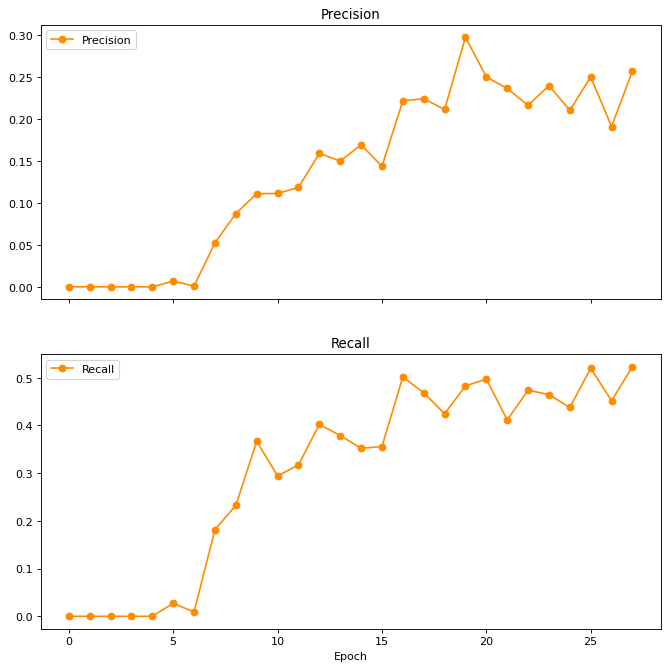

In [8]:
from utils.plot import plot_evaluator

_ = plot_evaluator(
    train_info.val_evaluators ,areaRng="all", iouThr=0.5, maxDets=10,
)


#### Plot loss curves.

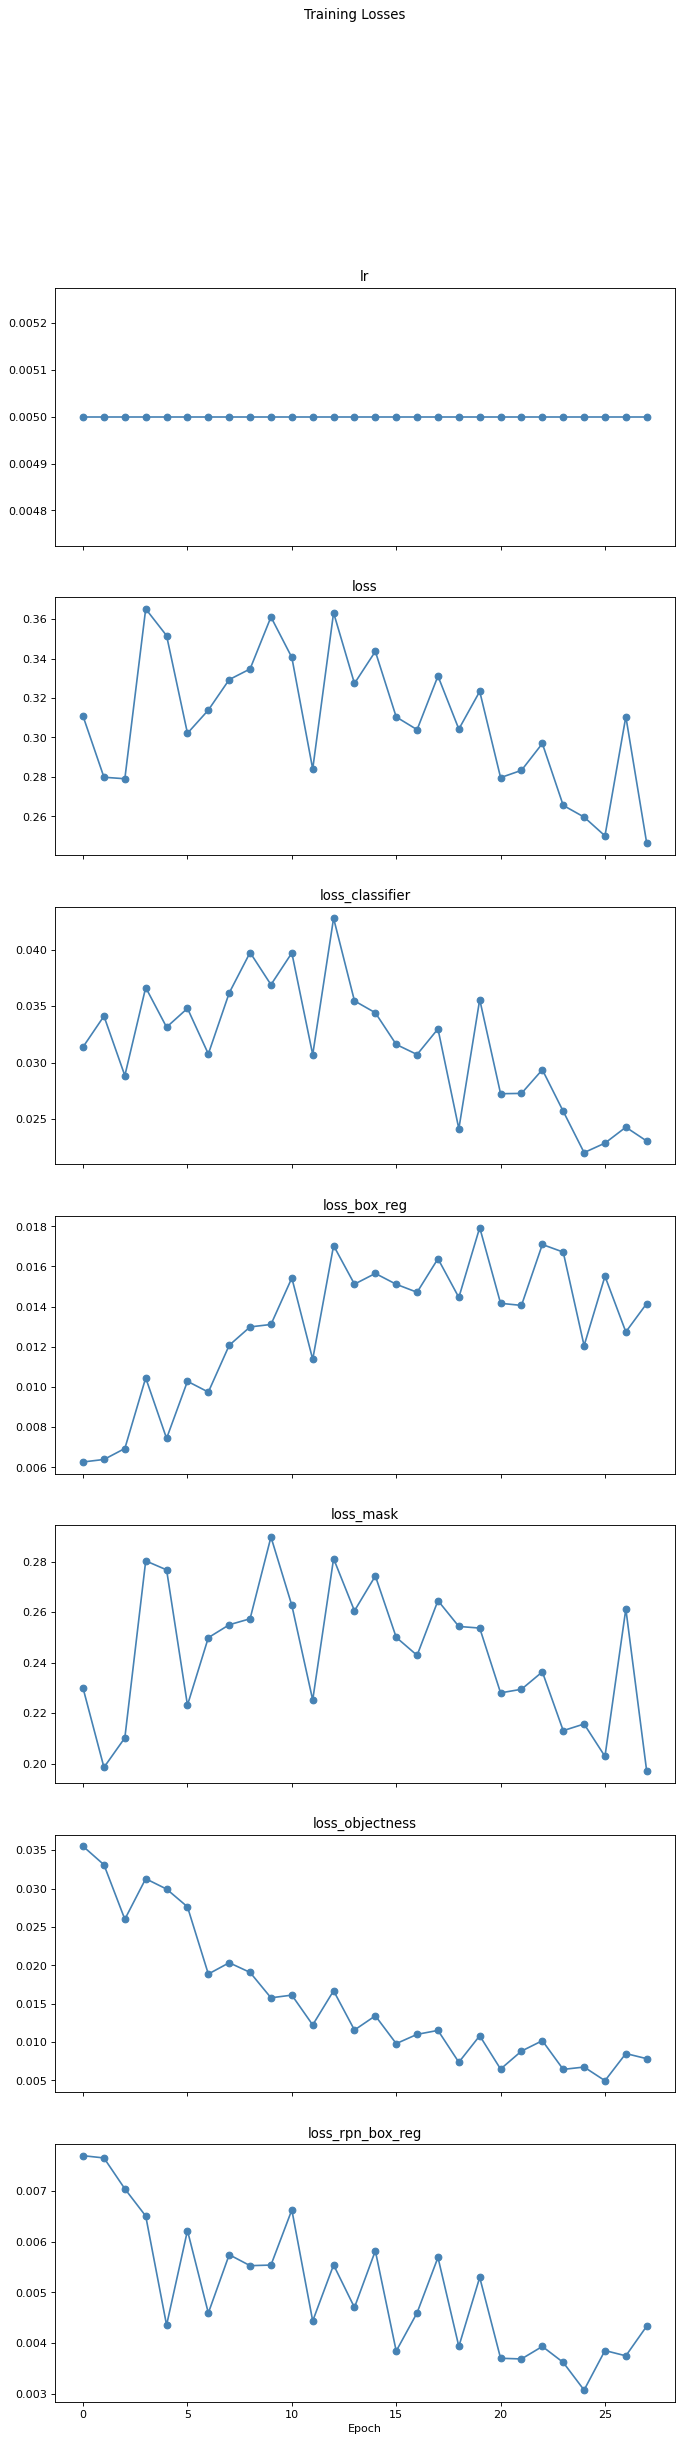

In [9]:
plot_loss(train_info.train_data)

#### print evaluation result.

In [10]:
train_info.test_evaluator.summarize()

IoU metric: bbox
 Average Precision  (AP) @[ IoBB=0.00:1.00 | area=   all | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoBB=0.50      | area=   all | maxDets= 10 ] = 0.255
 Average Precision  (AP) @[ IoBB=0.75      | area=   all | maxDets= 10 ] = 0.155
 Average Precision  (AP) @[ IoBB=0.00:1.00 | area= small | maxDets= 10 ] = -1.000
 Average Precision  (AP) @[ IoBB=0.00:1.00 | area=medium | maxDets= 10 ] = -1.000
 Average Precision  (AP) @[ IoBB=0.00:1.00 | area= large | maxDets= 10 ] = 0.214
 Average Recall     (AR) @[ IoBB=0.00:1.00 | area=   all | maxDets=  1 ] = 0.421
 Average Recall     (AR) @[ IoBB=0.00:1.00 | area=   all | maxDets=  6 ] = 0.513
 Average Recall     (AR) @[ IoBB=0.00:1.00 | area=   all | maxDets= 10 ] = 0.513
 Average Recall     (AR) @[ IoBB=0.00:1.00 | area= small | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoBB=0.00:1.00 | area=medium | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoBB=0.00:1.00 | area= large | maxDets= 10 ] = 0.513
IoU met

## [Ajustable Section 2] Define the dicom_id you want to check. And, set the threshold for bounding boxes. 

In [11]:
dicom_id = '977eb09d-c5d88197-de0097d8-2a60dcb2-f3d335c8'

# Control score threshold for each class

In [12]:
model.roi_heads.score_thresh = 0.01 # initial threshold for all bounding boxes.

score_thres= {
    'Enlarged cardiac silhouette': 0.2,
    'Atelectasis': 0.2,
    'Pleural abnormality': 0.2,
    'Consolidation': 0.1,
    'Pulmonary edema': 0.05,
}

## Plot detections.

In [13]:
# [k for k , v in dict(detect_eval_dataset.df.dicom_id.value_counts()).items() if v >=5]

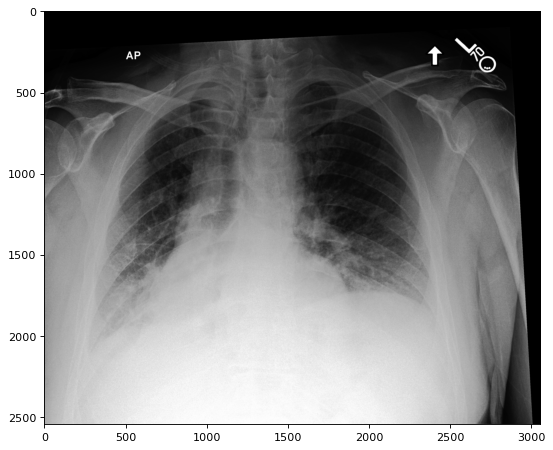

In [16]:
# from data.dataset import collate_fn
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# import PIL

# dataset = detect_eval_dataset

# for dicom_id in ['977eb09d-c5d88197-de0097d8-2a60dcb2-f3d335c8']:

#     idxs = detect_eval_dataset.get_idxs_from_dicom_id(dicom_id)
#     fig, axes = plt.subplots(1, len(idxs), figsize=(len(idxs)*8, 10), dpi=80, sharex=True)

#     for i, idx in enumerate(idxs):
#         data = collate_fn([dataset[idx]])
#         data = dataset.prepare_input_from_data(data, device)
#         target = data[-1][0]
#         gt_recs = []
#         # fig.suptitle(dicom_id)

#         plot_ax = axes[i] if len(idxs) > 1 else axes

#         img = PIL.Image.open(target["image_path"]).convert("RGB")
#         plot_ax.imshow(img)

#         for label, bbox in zip(
#                 target["labels"].detach().cpu().numpy(), target["boxes"].detach().cpu().numpy()
#             ):
#             disease = detect_eval_dataset.label_idx_to_disease(label)
#             c = disease_cmap['solid'][disease]
#             gt_recs.append(
#                 Rectangle(
#                     (bbox[0], bbox[1]),
#                     bbox[2] - bbox[0],
#                     bbox[3] - bbox[1],
#                     fill=False,
#                     color=c,
#                     linewidth=2,
#                 )
#             )
#             plot_ax.text(bbox[0], bbox[1], disease, color="black", backgroundcolor=c)

#         for rec in gt_recs:
#             plot_ax.add_patch(rec)

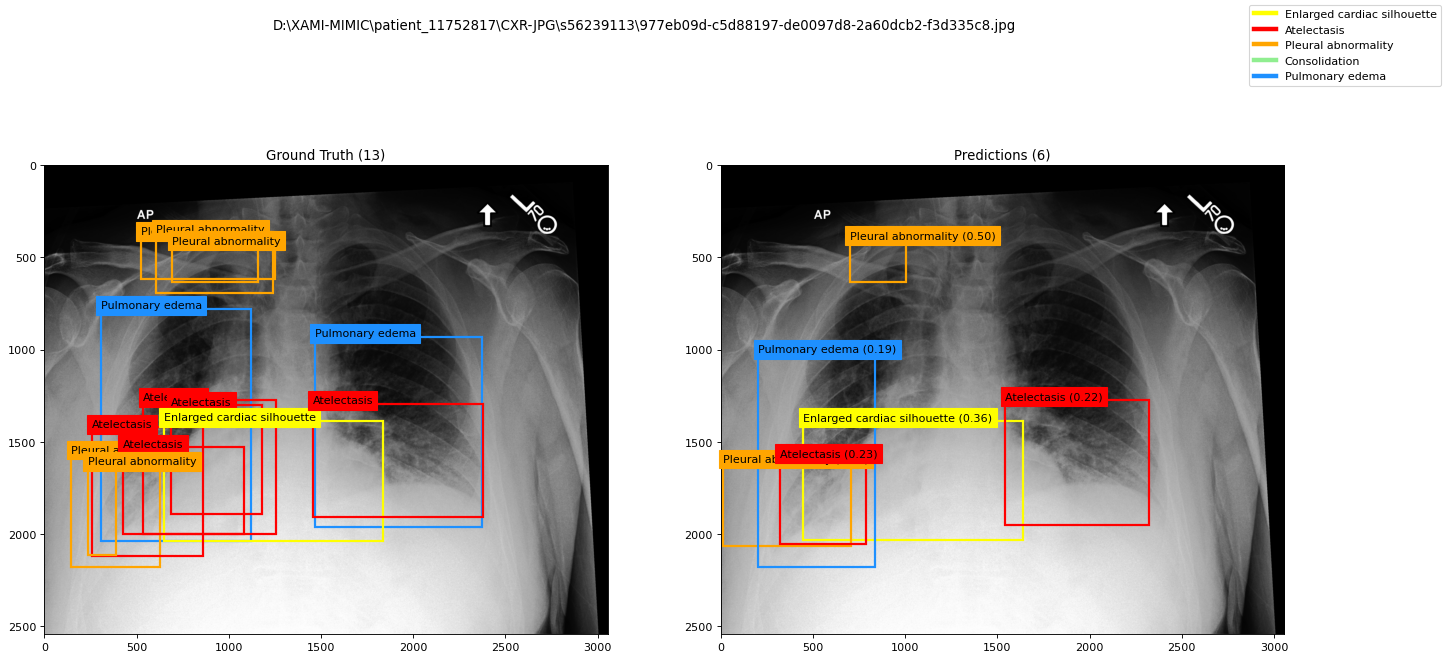

In [27]:
%matplotlib inline
idx= detect_eval_dataset.get_idxs_from_dicom_id(dicom_id)[0]

plot_result(
    model=model,
    dataset=detect_eval_dataset,
    device=device,
    idx= idx,
    legend_elements= legend_elements,
    disease_cmap =disease_cmap,
    seg=False,
    seg_thres=0.5,
    score_thres = score_thres,
)